<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Instructions" data-toc-modified-id="Instructions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Instructions</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#View-Baumgartner_C-N.pb-file" data-toc-modified-id="View-Baumgartner_C-N.pb-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>View Baumgartner_C-N.pb file</a></span></li><li><span><a href="#Train-Benchmarks" data-toc-modified-id="Train-Benchmarks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train Benchmarks</a></span><ul class="toc-item"><li><span><a href="#Baumgartner_C-N" data-toc-modified-id="Baumgartner_C-N-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Baumgartner_C-N</a></span><ul class="toc-item"><li><span><a href="#Set-up-4-domains" data-toc-modified-id="Set-up-4-domains-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Set up 4 domains</a></span></li><li><span><a href="#Create-Dataset" data-toc-modified-id="Create-Dataset-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Create Dataset</a></span></li><li><span><a href="#train-benchmarks-=-bm" data-toc-modified-id="train-benchmarks-=-bm-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>train benchmarks = bm</a></span></li><li><span><a href="#Save-Benchmarks" data-toc-modified-id="Save-Benchmarks-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Save Benchmarks</a></span></li><li><span><a href="#Load-Benchmarks" data-toc-modified-id="Load-Benchmarks-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>Load Benchmarks</a></span></li></ul></li></ul></li><li><span><a href="#Optimisation" data-toc-modified-id="Optimisation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimisation</a></span><ul class="toc-item"><li><span><a href="#Learning-how-the-Random-strategy-works" data-toc-modified-id="Learning-how-the-Random-strategy-works-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Learning how the Random strategy works</a></span></li><li><span><a href="#Run-strategies" data-toc-modified-id="Run-strategies-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Run strategies</a></span></li><li><span><a href="#multitask-BO" data-toc-modified-id="multitask-BO-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>multitask BO</a></span></li><li><span><a href="#Plot-a-results" data-toc-modified-id="Plot-a-results-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Plot a results</a></span></li></ul></li><li><span><a href="#Plot-all-results-(12-graphs)" data-toc-modified-id="Plot-all-results-(12-graphs)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot all results (12 graphs)</a></span><ul class="toc-item"><li><span><a href="#define-pretraining-datasets" data-toc-modified-id="define-pretraining-datasets-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>define pretraining datasets</a></span></li><li><span><a href="#Load-Benchmarks" data-toc-modified-id="Load-Benchmarks-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Load Benchmarks</a></span></li><li><span><a href="#Produce-graphs" data-toc-modified-id="Produce-graphs-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Produce graphs</a></span></li></ul></li></ul></div>

# Instructions

Simply run the imports block and then all the blocks from 'Plot all results' header and down.

# Imports

In [1]:
# Import modules
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import math
import pandas as pd
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import os
#import wget

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import model_selection, metrics
from glob import glob
from IPython.display import clear_output

#summit
import summit
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
from summit import Runner
from summit.strategies import Random, SOBO, MultitoSingleObjective, STBO, MTBO
from summit.benchmarks import SnarBenchmark
import pkg_resources
import pathlib
import random


# View Baumgartner_C-N.pb file

In [2]:
pb = '../data/baumgartner_C-N/baumgartner_C-N.pb'

# Load Dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

# Ensure dataset validates
valid_output = validations.validate_message(data)

# Convert dataset to pandas dataframe
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)

# View dataframe
df

,"inputs[""Quench""].components[0].identifiers[0].value","inputs[""Quench""].components[0].identifiers[1].value","inputs[""Quench""].components[0].amount.volume.value","inputs[""Catalyst""].components[0].identifiers[0].value","inputs[""Catalyst""].components[0].identifiers[1].value","inputs[""Catalyst""].components[0].amount.moles.value","inputs[""Internal_Standard""].components[0].amount.mass.value","inputs[""Base""].components[0].identifiers[0].value","inputs[""Base""].components[0].identifiers[1].value","inputs[""Base""].components[0].amount.moles.value",...,workups[0].input.components[0].identifiers[0].value,workups[0].input.components[0].identifiers[1].value,workups[0].input.components[0].amount.volume.value,workups[0].amount.volume.value,outcomes[0].reaction_time.value,outcomes[0].products[0].identifiers[0].value,outcomes[0].products[0].identifiers[1].value,outcomes[0].products[0].measurements[0].authentic_standard.identifiers[0].value,outcomes[0].products[0].measurements[0].authentic_standard.identifiers[1].value,outcomes[0].products[0].measurements[0].percentage.value
0,2-MeTHF,O1C(C)CCC1,15.0,cycloPd EPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.140643,157.130951,BTMG,CC(C)(C)N=C(N(C)C)N(C)C,37.473145,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,1324.577759,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,61.873035
1,2-MeTHF,O1C(C)CCC1,15.0,cycloPd EPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.140643,157.130951,DBU,C1CCC2=NCCCN2CC1,26.301455,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,374.843445,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,1.446805
2,2-MeTHF,O1C(C)CCC1,15.0,cycloPd EPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.140643,157.130951,DBU,C1CCC2=NCCCN2CC1,37.446136,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,1296.335205,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,21.348686
3,2-MeTHF,O1C(C)CCC1,15.0,cycloPd EPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.140643,157.130951,TEA,CCN(CC)CC,14.349244,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,595.096008,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,0.274913
4,2-MeTHF,O1C(C)CCC1,15.0,cycloPd EPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.140643,157.130951,BTMG,CC(C)(C)N=C(N(C)C)N(C)C,14.922934,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,1346.552979,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,4-methyl-N-phenylaniline,CC1=CC=C(C=C1)NC2=CC=CC=C2,54.948227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,2-MeTHF,O1C(C)CCC1,15.0,cycloPd tBuBrettPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.266644,156.398926,TEA,CCN(CC)CC,15.066707,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,73.882225,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,0.100000
370,2-MeTHF,O1C(C)CCC1,15.0,cycloPd tBuBrettPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.266644,156.398926,MTBD,CN1CCCN2C1=NCCC2,15.088326,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,76.790390,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,0.100000
371,2-MeTHF,O1C(C)CCC1,15.0,cycloPd tBuBrettPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.266644,156.398926,DBU,C1CCC2=NCCCN2CC1,14.933876,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,1294.963013,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,5.087716
372,2-MeTHF,O1C(C)CCC1,15.0,cycloPd tBuBrettPhos 4-Chlorotoluene,C1CC=CCCC=C1.C[Si](C)(C)C[Pd]C[Si](C)(C)C.CC(C...,0.266644,156.398926,MTBD,CN1CCCN2C1=NCCC2,45.032852,...,2-MeTHF,O1C(C)CCC1,15.0,30.0,81.582664,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,4-(p-tolyl)morpholine,CC1=CC=C(C=C1)N2CCOCC2,0.100000


In [3]:
max(df['outcomes[0].products[0].measurements[0].percentage.value'])

103.16002655029297

In [31]:
# Check for NaN values
print(f'number of NaN values: {df.isnull().sum().sum()}')

# Show column counts
df.info()

number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 37 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   inputs["Catalyst"].components[0].identifiers[0].value                            374 non-null    object 
 1   inputs["Catalyst"].components[0].identifiers[1].value                            374 non-null    object 
 2   inputs["Catalyst"].components[0].amount.moles.value                              374 non-null    float64
 3   inputs["Electrophile"].components[0].amount.moles.value                          374 non-null    float64
 4   inputs["Electrophile"].components[1].amount.mass.value                           374 non-null    float64
 5   inputs["Electrophile"].components[2].identifiers[0].value                        374 non-null   

In [4]:
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["Catalyst"].components[0].identifiers[0].value',
              'inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value',
              'inputs["Nucleophile"].components[0].identifiers[0].value',
              'outcomes[0].reaction_time.value',
              'conditions.temperature.setpoint.value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
df = df[model_cols]
df

,"inputs[""Catalyst""].components[0].identifiers[0].value","inputs[""Base""].components[0].identifiers[0].value","inputs[""Solvent""].components[0].identifiers[0].value","inputs[""Nucleophile""].components[0].identifiers[0].value",outcomes[0].reaction_time.value,conditions.temperature.setpoint.value,outcomes[0].products[0].measurements[0].percentage.value
0,cycloPd EPhos 4-Chlorotoluene,BTMG,2-MeTHF,Aniline,1324.577759,65.0,61.873035
1,cycloPd EPhos 4-Chlorotoluene,DBU,2-MeTHF,Aniline,374.843445,65.0,1.446805
2,cycloPd EPhos 4-Chlorotoluene,DBU,2-MeTHF,Aniline,1296.335205,100.0,21.348686
3,cycloPd EPhos 4-Chlorotoluene,TEA,2-MeTHF,Aniline,595.096008,30.0,0.274913
4,cycloPd EPhos 4-Chlorotoluene,BTMG,2-MeTHF,Aniline,1346.552979,65.0,54.948227
...,...,...,...,...,...,...,...
369,cycloPd tBuBrettPhos 4-Chlorotoluene,TEA,2-MeTHF,Morpholine,73.882225,30.0,0.100000
370,cycloPd tBuBrettPhos 4-Chlorotoluene,MTBD,2-MeTHF,Morpholine,76.790390,30.0,0.100000
371,cycloPd tBuBrettPhos 4-Chlorotoluene,DBU,2-MeTHF,Morpholine,1294.963013,30.0,5.087716
372,cycloPd tBuBrettPhos 4-Chlorotoluene,MTBD,2-MeTHF,Morpholine,81.582664,100.0,0.100000


# Train Benchmarks
https://gosummit.readthedocs.io/en/latest/tutorials/new_benchmarks.html

## Baumgartner_C-N

### Set up 4 domains

We are going to manipulate:
- Ligand (precatalyst is always the same)
- Base
- Solvent
- Temperature
- Reaction time

We will create 4 domains, one for each nucleophile

Objective: Maximise yield

Decision variables

The precatalyst is always the same: https://www.strem.com/catalog/v/46-0308/51/palladium_225931-80-6

The additive is always the same: 4-Chlorotoluene

The ligand changes

In [5]:
# aniline_domain = Domain()
# benzamide_domain = Domain()
# phenethylamine_domain = Domain()
# morpholine_domain = Domain()

# domain_list = [aniline_domain,benzamide_domain,phenethylamine_domain,morpholine_domain]

domain = Domain()

# Decision variables
des_1 = "Catalyst"
domain += CategoricalVariable(
    name='inputs["Catalyst"].components[0].identifiers[0].value',
    description=des_1,
    levels=[
        'cycloPd tBuXPhos 4-Chlorotoluene', 
         'cycloPd EPhos 4-Chlorotoluene', 
         'cycloPd AlPhos 4-Chlorotoluene', 
         'cycloPd tBuBrettPhos 4-Chlorotoluene',
    ],
)


# Decision variables
des_3 = "Base"
domain += CategoricalVariable(
    name='inputs["Base"].components[0].identifiers[0].value',
    description=des_3,
    levels=[
        "TEA",
        "Triethylamine",
        "TMG",
        "BTMG",
        "DBU",
        "MTBD",
        "BTTP",
        "P2Et",
    ],
)

# Decision variables
des_4 = "Solvent"
domain += CategoricalVariable(
    name='inputs["Solvent"].components[0].identifiers[0].value',
    description=des_4,
    levels=[
        "2-MeTHF",
        "DMSO",
    ],
)

des_5 = "Residence time in seconds (s)"
domain += ContinuousVariable(name="outcomes[0].reaction_time.value", description=des_5, bounds=[60, 6000])

des_6 = "Reactor temperature in degrees Celsius (ºC)"
domain += ContinuousVariable(
    name="conditions.temperature.setpoint.value", description=des_6, bounds=[30, 110]
)


# Objectives
des_7 = "Yield"
domain += ContinuousVariable(
    name="outcomes[0].products[0].measurements[0].percentage.value",
    description=des_5,
    bounds=[0, 105],
    is_objective=True,
    maximize=True,
)

In [6]:
domain

Name,Type,Description,Values
"inputs[""Catalyst""].components[0].identifiers[0].value","categorical, input",Catalyst,4 levels
"inputs[""Base""].components[0].identifiers[0].value","categorical, input",Base,8 levels
"inputs[""Solvent""].components[0].identifiers[0].value","categorical, input",Solvent,2 levels
outcomes[0].reaction_time.value,"continuous, input",Residence time in seconds (s),"[60,6000]"
conditions.temperature.setpoint.value,"continuous, input",Reactor temperature in degrees Celsius (ºC),"[30,110]"
outcomes[0].products[0].measurements[0].percentage.value,"continuous, maximize objective",Residence time in seconds (s),"[0,105]"


### Create Dataset

We need 4 datasets, one for each nucleophile

In [7]:
aniline_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Aniline']
benzamide_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Benzamide']
phenethylamine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Phenethylamine']
morpholine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Morpholine']

In [8]:
# shuffle df
aniline_df = aniline_df.sample(frac=1)
aniline_ds = DataSet.from_df(aniline_df)

benzamide_df = aniline_df.sample(frac=1)
benzamide_ds = DataSet.from_df(benzamide_df)

phenethylamine_df = aniline_df.sample(frac=1)
phenethylamine_ds = DataSet.from_df(phenethylamine_df)

morpholine_df = aniline_df.sample(frac=1)
morpholine_ds = DataSet.from_df(morpholine_df)


### train benchmarks = bm

In [9]:
aniline_bm = ExperimentalEmulator(model_name='aniline_bm', domain=domain, dataset=aniline_ds)
aniline_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.68801904, 1.75159001, 1.6194849 , 1.65805006, 1.80589604]),
 'score_time': array([0.00477505, 0.00459599, 0.00422096, 0.00435305, 0.00581408]),
 'val_r2': array([0.7985149 , 0.82589803, 0.82667912, 0.79472538, 0.75826843]),
 'val_neg_root_mean_squared_error': array([-18.58237839, -18.0384903 , -17.16369629, -19.82276344,
        -19.82283783])}

In [10]:
benzamide_bm = ExperimentalEmulator(model_name='aniline_bm', domain=domain, dataset=benzamide_ds)
benzamide_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.61781573, 1.56631303, 1.57094193, 1.5711329 , 1.69201803]),
 'score_time': array([0.00463414, 0.00455117, 0.00447392, 0.00451922, 0.00432897]),
 'val_r2': array([0.84857807, 0.8358712 , 0.82947235, 0.805169  , 0.77935707]),
 'val_neg_root_mean_squared_error': array([-16.84973526, -16.25414467, -17.69269943, -18.78605843,
        -18.32606506])}

In [11]:
phenethylamine_bm = ExperimentalEmulator(model_name='aniline_bm', domain=domain, dataset=phenethylamine_ds)
phenethylamine_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.70235991, 2.21341705, 1.85301089, 1.82779074, 1.87450099]),
 'score_time': array([0.00557899, 0.00708103, 0.00463915, 0.00482297, 0.00433803]),
 'val_r2': array([0.77367728, 0.81861632, 0.74069721, 0.67892024, 0.86028363]),
 'val_neg_root_mean_squared_error': array([-18.32055855, -16.30122948, -22.40821075, -23.23147774,
        -15.44098568])}

In [12]:
morpholine_bm = ExperimentalEmulator(model_name='aniline_bm', domain=domain, dataset=morpholine_ds)
morpholine_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.65086317, 1.58528519, 1.59357023, 1.60280871, 1.66838694]),
 'score_time': array([0.00454497, 0.00464487, 0.00447059, 0.00452209, 0.00426221]),
 'val_r2': array([0.77340633, 0.84397712, 0.81863542, 0.82188106, 0.86217086]),
 'val_neg_root_mean_squared_error': array([-20.79458046, -15.03976059, -17.3469162 , -18.34524155,
        -15.573946  ])}

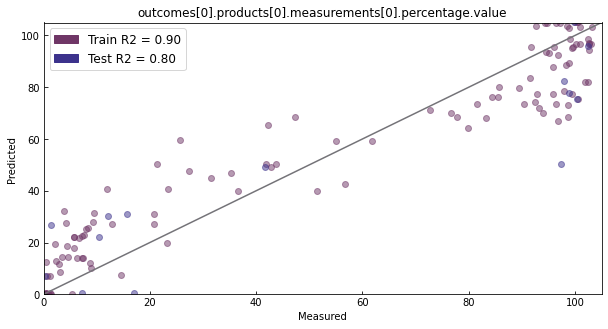

In [13]:
#Parity plots
fig, ax = morpholine_bm.parity_plot(include_test=True)

In [14]:
#Test out a set of conditions on the benchmark
conditions = [["cycloPd EPhos 4-Chlorotoluene", 'BTMG', '2-MeTHF', 1324, 65.0]]
conditions = DataSet(conditions, columns=[v.name for v in domain.input_variables])
morpholine_bm.run_experiments(conditions)

,"inputs[""Catalyst""].components[0].identifiers[0].value","inputs[""Base""].components[0].identifiers[0].value","inputs[""Solvent""].components[0].identifiers[0].value",outcomes[0].reaction_time.value,conditions.temperature.setpoint.value,outcomes[0].products[0].measurements[0].percentage.value,computation_t,experiment_t,strategy
0,cycloPd EPhos 4-Chlorotoluene,BTMG,2-MeTHF,1324,65.0,59.404846,0.0,0.024156,NaN


### Save Benchmarks

In [15]:
# Save it
aniline_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/aniline_emulator")

benzamide_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/benzamide_emulator")

phenethylamine_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/phenethylamine_emulator")

morpholine_bm.save(save_dir="/Users/dsw46/OneDrive - University of Cambridge/Cambridge\
/Projects/multitask/multitask/data/baumgartner_C-N/morpholine_emulator")

### Load Benchmarks

In [25]:
# Load them
aniline_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/aniline_emulator")
benzamide_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/benzamide_emulator")
phenethylamine_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/phenethylamine_emulator")
morpholine_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/morpholine_emulator")

In [26]:
#add meta column

aniline_ds[("task", "METADATA")] = 0
benzamide_ds[("task", "METADATA")] = 0
phenethylamine_ds[("task", "METADATA")] = 0
morpholine_ds[("task", "METADATA")] = 0

NameError: name 'aniline_ds' is not defined

# Optimisation

## Learning how the Random strategy works

In [4]:
#Set up the experiment
exp = baumgartner_cn
exp.reset()
# Instantiate random sampling strategy
strategy = Random(exp.domain)

# Use the runner to run closed loop optimisation
r = Runner(strategy=strategy, experiment=exp, max_iterations=50)
r.run()


In [5]:
r.experiment.data

,"inputs[""Catalyst""].components[0].identifiers[0].value","inputs[""Nucleophile""].components[0].identifiers[0].value","inputs[""Base""].components[0].identifiers[0].value","inputs[""Solvent""].components[0].identifiers[0].value",outcomes[0].reaction_time.value,conditions.temperature.setpoint.value,outcomes[0].products[0].measurements[0].percentage.value,computation_t,experiment_t,strategy
0,cycloPd tBuXPhos 4-Chlorotoluene,Aniline,BTTP,DMSO,5893.391328,39.037304,51.531013,0.0,0.031588,Random
1,cycloPd AlPhos 4-Chlorotoluene,Aniline,BTTP,2-MeTHF,1782.167439,78.857304,105.000000,0.011679,0.033523,Random
2,cycloPd EPhos 4-Chlorotoluene,Phenethylamine,TEA,DMSO,3211.940753,46.918225,0.000000,0.010716,0.028566,Random
3,cycloPd EPhos 4-Chlorotoluene,Aniline,BTMG,DMSO,4705.788330,88.979451,48.286976,0.011475,0.027955,Random
4,cycloPd EPhos 4-Chlorotoluene,Aniline,DBU,2-MeTHF,2252.655043,90.303206,28.887344,0.009549,0.027082,Random
5,cycloPd AlPhos 4-Chlorotoluene,Aniline,MTBD,DMSO,4099.706201,92.286932,92.656807,0.008956,0.024352,Random
6,cycloPd AlPhos 4-Chlorotoluene,Benzamide,MTBD,DMSO,5952.445800,33.746432,43.536140,0.009752,0.028418,Random
7,cycloPd tBuXPhos 4-Chlorotoluene,Morpholine,MTBD,2-MeTHF,5055.771261,62.466915,0.000000,0.009342,0.028177,Random
8,cycloPd tBuBrettPhos 4-Chlorotoluene,Benzamide,BTTP,2-MeTHF,4006.385207,80.285205,42.910522,0.007398,0.025644,Random
9,cycloPd tBuBrettPhos 4-Chlorotoluene,Morpholine,BTMG,2-MeTHF,2872.073481,50.796707,15.564214,0.009582,0.027209,Random


In [ ]:
random_yield = r.experiment.data['outcomes[0].products[0].measurements[0].percentage.value']
plt.plot(random_yield)

In [ ]:
random_yield_max = []
for i in range(len(random_yield)):
    if i == 0:
        j = random_yield[i]
    else:
        j = max(random_yield[i],random_yield_max[i-1])
    random_yield_max+=[j]

In [ ]:
plt.plot(random_yield_max)

In [ ]:
type(exp.domain['inputs["Base"].components[0].identifiers[0].value'].levels[0])

In [ ]:
exp.domain.num_continuous_dimensions()

In [ ]:
#Set up the experiment
exp.reset()
exp = CN_benchmark

# Instantiate sampling strategy
strategy = SOBO(exp.domain)

# Use the runner to run closed loop optimisation
r = Runner(strategy=strategy, experiment=exp, max_iterations=50)
r.run()


In [ ]:
SOBO_yield = r.experiment.data['outcomes[0].products[0].measurements[0].percentage.value']
plt.plot(SOBO_yield)

In [ ]:
SOBO_yield_max = []
for i in range(len(SOBO_yield)):
    if i == 0:
        j = SOBO_yield[i]
    else:
        j = max(SOBO_yield[i],SOBO_yield_max[i-1])
    SOBO_yield_max+=[j]
plt.plot(random_yield_max)

## Run strategies
- Random strategy
- SOBO: Single Objective Bayesian Optimisation
- STBO: Single Task Bayesian Optimisation
- MTBO: Multitask Bayesian Optimisation

In [101]:
def run_random(exp, max_iterations=10, random_state=np.random.RandomState(3)):
    exp.reset()
    strategy = Random(exp.domain, 
                    random_state=random_state)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_sobo(exp, max_iterations=10, categorical_method="one-hot"):
    exp.reset()
    strategy = SOBO(exp.domain, 
                    categorical_method=categorical_method)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_mtbo(exp, pt_data, max_iterations=10, task=1):
    exp.reset()
    strategy = MTBO(exp.domain, 
                    pretraining_data=pt_data,
                    categorical_method="one-hot", 
                    task=task)
    r = summit.Runner(strategy=strategy,
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def make_average_plot(results: [summit.Runner], ax, label=None, color=None):
    objective = results[0].experiment.domain.output_variables[0].name
    yields = [r.experiment.data[objective] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=2, color=color)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1, color=color)

def make_comparison_plot(*args):
    fig, ax = plt.subplots(1)
    for arg in args:
        make_average_plot(arg['results'], ax, label=arg["label"], color=arg["color"])
    fontdict = fontdict={"size":12}
    ax.legend(loc = "lower right", prop=fontdict)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
    ax.set_ylabel('Yield', fontdict=fontdict)
    ax.set_xlabel('Reactions', fontdict=fontdict)
    ax.tick_params(direction='in')
    return fig, ax

In [102]:
N_REPEATS = 10
MAX_ITERATIONS = 20

In [19]:
#Random
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = aniline_bm
    result = run_random(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"../data/baumgartner_C-N/results/aniline_random_{i}.json")
    clear_output(wait=True)

Repeat 9


In [20]:
#Single-Objective Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = aniline_bm
    result = run_sobo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"../data/baumgartner_C-N/results/aniline_SOBO_{i}.json")
    clear_output(wait=True)

Repeat 9


## multitask BO

In [11]:
#4 nucleophiles choose 2
# Pretrain with data on nucleophile A to predict best conditions for nucleophile B

In [167]:
#Define pretraining datasets for all 4 nucleophiles by adding a metadata column named 
# “task” that specfies the task for all data.

aniline_ds[("task", "METADATA")] = 0
benzamide_ds[("task", "METADATA")] = 0
phenethylamine_ds[("task", "METADATA")] = 0
morpholine_ds[("task", "METADATA")] = 0

In [41]:
benzamide_ds

,"inputs[""Catalyst""].components[0].identifiers[0].value","inputs[""Base""].components[0].identifiers[0].value","inputs[""Solvent""].components[0].identifiers[0].value","inputs[""Nucleophile""].components[0].identifiers[0].value",outcomes[0].reaction_time.value,conditions.temperature.setpoint.value,outcomes[0].products[0].measurements[0].percentage.value,task
99,cycloPd tBuBrettPhos 4-Chlorotoluene,TMG,2-MeTHF,Aniline,1072.451294,62.700001,35.341927,0
34,cycloPd EPhos 4-Chlorotoluene,BTMG,2-MeTHF,Aniline,1225.093018,100.0,81.591469,0
108,cycloPd AlPhos 4-Chlorotoluene,BTMG,2-MeTHF,Aniline,75.116295,30.0,92.922897,0
82,cycloPd tBuBrettPhos 4-Chlorotoluene,BTMG,2-MeTHF,Aniline,1240.719971,30.0,101.967148,0
67,cycloPd tBuXPhos 4-Chlorotoluene,TMG,2-MeTHF,Aniline,551.720581,100.0,96.87928,0
...,...,...,...,...,...,...,...,...
55,cycloPd tBuXPhos 4-Chlorotoluene,TEA,2-MeTHF,Aniline,1065.218872,100.0,12.92645,0
78,cycloPd tBuBrettPhos 4-Chlorotoluene,TEA,2-MeTHF,Aniline,1250.931519,65.0,2.379203,0
1,cycloPd EPhos 4-Chlorotoluene,DBU,2-MeTHF,Aniline,374.843445,65.0,1.446805,0
79,cycloPd tBuBrettPhos 4-Chlorotoluene,DBU,2-MeTHF,Aniline,357.990479,30.0,51.484447,0


In [125]:
#Multi-Task Bayesian Optimization
for i in range(10):
    print(f"Repeat {i}")
    exp = aniline_bm
    result = run_mtbo(exp, benzamide_ds[0:10], max_iterations=MAX_ITERATIONS)
    result.save(f"../data/baumgartner_C-N/results/MTBO_{i}.json")
    clear_output(wait=True)


Repeat 1


## Plot a results

In [126]:
random_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/aniline_random_{i}.json") for i in range(10)]
sobo_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/aniline_SOBO_{i}.json") for i in range(10)]
mtbo10_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/MTBO_{i}.json") for i in range(10)]
mtbo50_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/MTBO_{i}.json") for i in range(10)]

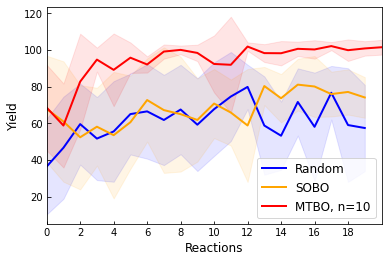

In [131]:
fig, ax = make_comparison_plot(
    dict(results=random_results, label="Random", color = 'blue'),
    dict(results=sobo_results, label="SOBO", color = 'orange'),
    dict(results=mtbo_results, label="MTBO, n=10", color = 'red'),
#    dict(results=mtbo_results_lists[1],label="MTBO, n=10"),
#    dict(results=mtbo_results_lists[2],label="MTBO, n=50")
)
#fig.savefig("figures/stbo_mtbo_kinetics_case1-2_noise_comparison.png", bbox_inches='tight', dpi=300)

In [136]:
random_indices = random.sample(range(0, 12), 3)

In [139]:
mylist

[5, 7, 2]

In [143]:
a = [1,2,3,4,5,6,7,8,9,10, 11,12]

In [153]:
accessed_mapping = map(a.__getitem__, mylist)
accessed_list = list(accessed_mapping)

In [156]:
len(aniline_ds)

131

# Plot all results (12 graphs)

In [31]:
class Nucleophile():
    
    def __init__(self, nucleophile, exp, N_REPEATS=10, MAX_ITERATIONS=20):
        self.nucleophile = nucleophile
        self.exp = exp
        self.N_REPEATS = N_REPEATS
        self.MAX_ITERATIONS = MAX_ITERATIONS
        
    def run_random(self, random_state=np.random.RandomState(3)):
        self.exp.reset()
        strategy = Random(self.exp.domain, 
                        random_state=random_state)
        r = summit.Runner(strategy=strategy, 
                          experiment=self.exp, 
                          max_iterations=self.MAX_ITERATIONS)
        r.run()
        return r

    def run_sobo(self, categorical_method="one-hot"):
        self.exp.reset()
        strategy = SOBO(self.exp.domain, 
                        categorical_method=categorical_method)
        r = summit.Runner(strategy=strategy, 
                          experiment=self.exp, 
                          max_iterations=self.MAX_ITERATIONS)
        r.run()
        return r

    def run_mtbo(self, pt_data, task=1):
        self.exp.reset()
        strategy = MTBO(self.exp.domain, 
                        pretraining_data=pt_data,
                        categorical_method="one-hot", 
                        task=task)
        r = summit.Runner(strategy=strategy,
                          experiment=self.exp, 
                          max_iterations=self.MAX_ITERATIONS)
        r.run()
        return r

    def make_average_plot(self, results: [summit.Runner], ax, label=None, color=None):
        objective = results[0].experiment.domain.output_variables[0].name
        yields = [r.experiment.data[objective] for r in results]
        yields = np.array(yields)
        mean_yield = np.mean(yields, axis=0)
        std_yield = np.std(yields, axis=0)
        x = np.arange(0, len(mean_yield), 1).astype(int)
        ax.plot(x, mean_yield, label=label, linewidth=2, color=color)
        ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1, color=color)

    def plot_figure(self, pt_name):
        #pt_name: name of nucleophile used for pretraining
        
        random_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_random_{i}.json") for i in range(10)]
        sobo_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_SOBO_{i}.json") for i in range(10)]
        mtbo10_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_{pt_name}_10_MTBO_{i}.json") for i in range(10)]
        #mtbo50_results = [summit.Runner.load(f"../data/baumgartner_C-N/results/{self.nucleophile}_{pt_name}_50_MTBO_{i}.json") for i in range(10)]
        
        fig, ax = self.make_comparison_plot(
            dict(results=random_results, label="Random", color = 'blue'),
            dict(results=sobo_results, label="SOBO", color = 'orange'),
            dict(results=mtbo10_results, label="MTBO, n=10", color = 'purple'),
            #dict(results=mtbo50_results,label="MTBO, n=50", color = 'green'),
            )
        #fig.savefig(f"figures/baumgartner_CN/{self.nucleophile}_pt_on_{pt_name}.png", bbox_inches='tight', dpi=300)
        
    def random_strategy(self):
        #Random
        for i in range(self.N_REPEATS):
            print(f"Repeat {i}")
            result = self.run_random()
            result.save(f"../data/baumgartner_C-N/results/{self.nucleophile}_random_{i}.json")
            clear_output(wait=True)
            
    def SOBO_strategy(self):
        #Single-Objective Bayesian Optimization
        for i in range(self.N_REPEATS):
            print(f"Repeat {i}")
            result = self.run_sobo()
            result.save(f"../data/baumgartner_C-N/results/{self.nucleophile}_SOBO_{i}.json")
            clear_output(wait=True)
            
    def MTBO_strategy(self, pt, pt_name, pt_samples):
    #pt = pretraining dataset
    #pt_name = string of the nucleophile used for pretraining
    #pt_samples = number of pretraining datapoints from pt, either 10 or 50
    #Multi-Task Bayesian Optimization
        for i in range(self.N_REPEATS):
            #randomly select pt_samples sample indices for pretraining
            #random_indices = random.sample(range(0, len(pt)), pt_samples)
            #random_samples = pt.loc[random_indices]
            pt_data = pt.loc[0:pt_samples] 
            
            print(f"Repeat {i}")
            #result = self.run_mtbo(random_samples)
            result = self.run_mtbo(pt_data)
            result.save(f"../data/baumgartner_C-N/results/{self.nucleophile}_{pt_name}_{pt_samples}_MTBO_{i}.json")
            clear_output(wait=True)

    def make_comparison_plot(self, *args):
        fig, ax = plt.subplots(1)
        for arg in args:
            self.make_average_plot(arg['results'], ax, label=arg["label"], color=arg["color"])
        fontdict = fontdict={"size":12}
        ax.legend(loc = "lower right", prop=fontdict)
        ax.set_xlim(0,20)
        ax.set_xticks(np.arange(0, 20, 2).astype(int))
        ax.set_ylabel('Yield', fontdict=fontdict)
        ax.set_xlabel('Reactions', fontdict=fontdict)
        ax.tick_params(direction='in')
        return fig, ax 
    

## define pretraining datasets

In [23]:
pb = '../data/baumgartner_C-N/baumgartner_C-N.pb'
data = message_helpers.load_message(pb, dataset_pb2.Dataset)
valid_output = validations.validate_message(data)
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["Catalyst"].components[0].identifiers[0].value',
              'inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value',
              'inputs["Nucleophile"].components[0].identifiers[0].value',
              'outcomes[0].reaction_time.value',
              'conditions.temperature.setpoint.value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
df = df[model_cols]

aniline_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Aniline']
benzamide_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Benzamide']
phenethylamine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Phenethylamine']
morpholine_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Morpholine']

aniline_df.reset_index(inplace=True)
benzamide_df.reset_index(inplace=True)
phenethylamine_df.reset_index(inplace=True)
morpholine_df.reset_index(inplace=True)


aniline_ds = DataSet.from_df(aniline_df)
benzamide_ds = DataSet.from_df(benzamide_df)
phenethylamine_ds = DataSet.from_df(phenethylamine_df)
morpholine_ds = DataSet.from_df(morpholine_df)

#add meta column
aniline_ds[("task", "METADATA")] = 0
benzamide_ds[("task", "METADATA")] = 0
phenethylamine_ds[("task", "METADATA")] = 0
morpholine_ds[("task", "METADATA")] = 0


## Load Benchmarks

In [24]:
# Load them
aniline_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/aniline_emulator")
benzamide_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/benzamide_emulator")
phenethylamine_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/phenethylamine_emulator")
morpholine_bm = ExperimentalEmulator.load(model_name="aniline_bm", save_dir="../data/baumgartner_C-N/morpholine_emulator")

## Produce graphs

In [32]:
aniline = Nucleophile('aniline', aniline_bm)

In [6]:
aniline.random_strategy()

Repeat 9


In [7]:
aniline.SOBO_strategy()

Repeat 9


In [33]:
aniline.MTBO_strategy(benzamide_ds, 'benzamide', 10)

Repeat 3


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.

In [ ]:
aniline.MTBO_strategy(benzamide_ds, 'benzamide', 50)

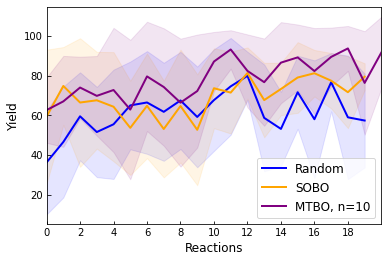

In [35]:
aniline.plot_figure('benzamide')